In [2]:
!sudo apt update
%pip install -q -U python-dotenv
%pip install -q -U pdf2image
!sudo apt install --yes poppler-utils
%pip install -q -U openai
%pip install -q -U pytesseract
!sudo apt install --yes tesseract-ocr
%pip install -q -U Unidecode

Get:1 file:/var/cuda-repo-ubuntu2204-12-0-local  InRelease [1575 B]
Get:1 file:/var/cuda-repo-ubuntu2204-12-0-local  InRelease [1575 B]
Hit:2 https://deb.nodesource.com/node_20.x nodistro InRelease                  
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease               
Hit:8 https://packagecloud.io/github/git-lfs/ubuntu jammy InRelease            
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
215 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://developer.download.nvidia.com/com

In [1]:
from dotenv import load_dotenv
from enum import Enum
from openai import OpenAI
from pdf2image import convert_from_bytes, convert_from_path
from PIL import Image
from pydantic import BaseModel
from tqdm import tqdm
from typing import List, Literal, Optional, Union
from unidecode import unidecode
from urllib.parse import urlparse, urlunparse
import json
import os
import pytesseract
import re
import requests
import tempfile
import unicodedata
import urllib
import base64


In [2]:
load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
WEIGHTS_AND_BIASES = os.environ["WEIGHTS_AND_BIASES"]
HF_TOKEN = os.environ["HF_TOKEN"]

In [3]:
DATASET_PATH = "./documents"
PDF_PATH = os.path.join(DATASET_PATH, "german_pdf_files")
IMAGE_PATH = os.path.join(DATASET_PATH, "german_img_files")

In [4]:
with open(os.path.join(PDF_PATH, "mapping.json"), "r", encoding="utf8") as json_file:
    mappings_pdf = json.load(json_file)
    print("Current number of PDFs:", len(mappings_pdf))


with open(os.path.join(IMAGE_PATH, "mapping.json"), "r", encoding="utf8") as json_file:
    mappings_img = json.load(json_file)
    print("Current number of images:", len(mappings_img))

with open(
    os.path.join(DATASET_PATH, "extraction.json"), "r", encoding="utf8"
) as json_file:
    extraction = json.load(json_file)
    print("Current number of metadata extractions:", len(extraction))

with open(os.path.join(DATASET_PATH, "transcripts.json"), "r", encoding="utf8") as json_file:
    transcripts = json.load(json_file)
    print("Current number of transcripts:", len(transcripts))

del mappings_img["https://www.geo-iburg.de/Bergaufsicht.pdf"]

Current number of PDFs: 18685
Current number of images: 16975
Current number of metadata extractions: 4702
Current number of transcripts: 12200


# Download Scraped PDF Files


In [8]:
!wget https://digitalcorpora.s3.amazonaws.com/corpora/files/CC-MAIN-2021-31-PDF-UNTRUNCATED/metadata/cc-provenance-20230303.csv.gz
!gunzip cc-provenance-20230303.csv.gz 

--2024-10-15 16:49:42--  https://digitalcorpora.s3.amazonaws.com/corpora/files/CC-MAIN-2021-31-PDF-UNTRUNCATED/metadata/cc-provenance-20230303.csv.gz
Resolving digitalcorpora.s3.amazonaws.com (digitalcorpora.s3.amazonaws.com)... 52.218.168.195, 52.92.235.73, 52.92.185.241, ...
Connecting to digitalcorpora.s3.amazonaws.com (digitalcorpora.s3.amazonaws.com)|52.218.168.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1293543097 (1.2G) [text/csv]
Saving to: ‘cc-provenance-20230303.csv.gz’

cc-provenance-20230 100%[===================>]   1.20G  14.6MB/s    in 90s     

2024-10-15 16:51:13 (13.7 MB/s) - ‘cc-provenance-20230303.csv.gz’ saved [1293543097/1293543097]

gzip: unrecognized option '--yes'
Try `gzip --help' for more information.


In [10]:
lines = []
with open("./cc-provenance-20230303.csv") as csv_file:
    for line in csv_file:
        lines.append(line)
header = lines[0]
content = lines[1:]

content = [line.split(",")[2] for line in content]


# filter all german urls
german_urls = []
for url in tqdm(content):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname is None:
        continue
    if hostname.endswith("de"):
        german_urls.append(url)

len(german_urls)

100%|██████████| 8410703/8410703 [00:40<00:00, 207007.45it/s]


590954

In [1]:
download_count = 0

for url in tqdm(german_urls):
    if url in mappings_pdf:
        continue

    decoded_str = urllib.parse.unquote(url)
    parsed_url = urlparse(decoded_str)
    file_name = parsed_url.hostname + "_" + os.path.basename(parsed_url.path)
    if not file_name.endswith(".pdf"):
        continue

    try:
        response = requests.get(url, timeout=10)
    except:
        continue

    if response.status_code == 200:
        with open(os.path.join(PDF_PATH, file_name), "wb") as file:
            file.write(response.content)
            mappings_pdf[url] = file_name

        download_count += 1

        # Dump mapping to JSON file every 200 downloads
        if download_count % 200 == 0:
            with open(os.path.join(PDF_PATH, "mapping.json"), "w") as json_file:
                json.dump(mappings_pdf, json_file)

# Final dump of mapping to JSON file
with open(os.path.join(PDF_PATH, "mapping.json"), "w") as json_file:
    json.dump(mappings_pdf, json_file)

NameError: name 'tqdm' is not defined

# PDFs to Images


In [7]:
for url, file_name in tqdm(mappings_pdf.items()):
    if url in mappings_img:
        continue
    pdf_path = os.path.join(PDF_PATH, file_name)
    pdf_path = unicodedata.normalize("NFC", pdf_path)
    try:
        with tempfile.TemporaryDirectory() as path:
            image_data = convert_from_path(
                pdf_path, output_folder=path, fmt="jpeg", first_page=1, last_page=1
            )[0]
            image_data.save(os.path.join(IMAGE_PATH, file_name.replace(".pdf", ".jpg")))
            mappings_img[url] = file_name.replace(".pdf", ".jpg")
            with open(os.path.join(IMAGE_PATH, "mapping.json"), "w") as f:
                json.dump(mappings_img, f)
    except:
        continue

 15%|█▌        | 2888/18685 [00:03<00:14, 1074.53it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (104680000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 40%|███▉      | 7396/18685 [00:10<00:11, 1020.25it/s]

 53%|█████▎    | 9874/18685 [00:17<00:14, 626.31it/s] 

# Transcribe Images

In [5]:
for url in tqdm(list(mappings_img.keys())):
    file_name = mappings_img[url]

    if url in transcripts:
        continue

    file_path = os.path.join(IMAGE_PATH, file_name)
    try:
        transcript = pytesseract.image_to_string(Image.open(file_path))
        transcripts[url] = transcript
    except:
        continue

    if len(transcripts) % 100 == 0:
        with open(os.path.join(DATASET_PATH, "transcripts.json"), "w") as f:
            json.dump(transcripts, f)


 72%|███████▏  | 12295/16974 [45:11<3:18:04,  2.54s/it]

 72%|███████▏  | 12298/16974 [45:14<1:57:47,  1.51s/it]

# Extract Attribute Infomration from Images

In [65]:
prompt = """You are an expert data analyst specializing in document analysis and information extraction.
            Your task is to carefully analyze a transcribed text from various types of documents (e.g., emails, letters, invoices, invitations)
            and extract all relevant attributes describing human or legal entities (Person, Organization, Institution, etc.) of the document.
                
            Here are EXAMPLES of attributes you should extract.
            This is not an exhaustive list, find more interesting attributes yourself.
            The attributes MUST directly describe the entity and must be directly extracted from the text.
            - Full Name (if available, separate first name and last name)
            - Complete Address (including street, city, state/province, postal code, country)
            - Phone Number(s) (specify if it's a landline, mobile, or fax)
            - Email Address
            - Any relevant identification numbers (e.g., Customer ID, Order Number, Invoice Number, License Key)
            - Company or Organization name (if applicable)
            - Job Title or Role (if mentioned)
            
            Remember, accuracy is crucial. If you're unsure about any piece of information, indicate your level of confidence or that the information is ambiguous.
            
            The main target of this analysis are documents that carry detailed information about entities e.g. invoices, business letters, etc.
            Give a score from 1 to 10 how good the document fits the quality criteria, 1 being very bad and 10 being very good.
            
            Please analyze the following transcribed text and provide your detailed extraction:
            """

In [62]:
class Attribute(BaseModel):
    key: str
    value: str

class Entity(BaseModel):
    name: str
    attributes: List[Attribute]

class Extraction(BaseModel):
    entities: List[Entity]
    score: int
    

In [66]:
from openai import OpenAI
from llama_index.core.llms import ChatMessage
from llama_index.core.program import FunctionCallingProgram
from tqdm import tqdm

# Initialize the OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

attribute_list = {}

for url in tqdm(list(transcripts.keys())[11:12]):
    transcript = transcripts[url]

    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": transcript}
    ]

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages
    )

    chatgpt_response = response.choices[0].message.content

    prompt_template_str = """You are an expert data analyst specializing in document analysis and information extraction.
    Your task is to carefully analyze a transcribed text from various types of documents (e.g., emails, letters, invoices, invitations)
    and extract all relevant attributes describing both the recipient and the sender of the document.
    """

    completion = client.beta.chat.completions.parse(    
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": prompt_template_str},
            {"role": "user", "content": chatgpt_response}
        ],
        response_format=Extraction,
    )

    output = completion.choices[0].message.parsed

    attribute_list[url] = output.dict()

with open(os.path.join(DATASET_PATH, "attributes.json"), "w") as f:
    json.dump(attribute_list, f)

100%|██████████| 1/1 [00:21<00:00, 21.23s/it]


In [67]:
url = list(attribute_list.keys())[0]
attribute_list[url]


{'entities': [{'name': 'MSK Industrieservice',
   'attributes': [{'key': 'Full Name', 'value': 'MSK Industrieservice'},
    {'key': 'Company Name', 'value': 'MNA Laboratuvarlari San. Tic. Ltd, Sti'},
    {'key': 'Complete Address',
     'value': 'Kiciikbakalkéy Mahallesi Yenidogan Ca. No:21, Atasehir, Istanbul, Turkey'},
    {'key': 'Notified Body Number', 'value': '2841'},
    {'key': 'Product Classification', 'value': 'FFP2'},
    {'key': 'Product Name', 'value': 'Komfort2o Atemschutzmaske'},
    {'key': 'Compliance Standard', 'value': 'EN149:2001+A1:2009'},
    {'key': 'CE Certification',
     'value': 'CE-Kennzeichnung gem. der Verordnung (EU) 2016/425'},
    {'key': 'Storage Conditions', 'value': 'Cold (-20 to +40°C), Dry'},
    {'key': 'Humidity', 'value': '<80%'},
    {'key': 'Exposure Conditions',
     'value': 'Protection against direct UV and sunlight exposure'},
    {'key': 'Instructions for Disposal',
     'value': 'The masks may be contaminated with harmful substances and 

In [51]:
attribute_list

{'http://olympiaschnittmuster.de/pdf/nodata.pdf': None,
 'https://dgao.de/wp-content/uploads/2021/07/W3_Laser_und_Oberflaechentechnik_dt_211020.pdf': None,
 'https://www.posten-boerse.de/images/downloads/Filialanalyse_Neueroeffnung_Posten-Boerse_in_49401_Damme_Muehlenstrasse_31.pdf': None,
 'https://conceptbau.de/wp-content/uploads/2021/07/MBA2_163.pdf': None,
 'https://bkv-mrw.de/anhaenge/111072021003202.pdf': None,
 'https://www.bildungshaus-salmuenster.de/bildungshaussalmuenster/pdf/2021-2_Veranstaltungen/Veranstaltungsraster-2021-DIN-A5-Version-Stand-Juli-2021doc.pdf': None,
 'https://shop.strato.de/WebRoot/Store19/Shops/63268978/MediaGallery/Downloads/Muster-Widerrufsformular.pdf': None,
 'https://hormoneundmehr.de/files/content/download/Beschwerden-Fragebogen-fuer-die-Frau.pdf': None,
 'https://www.kulmeck.de/wp-content/uploads/2021/07/kulmeck_daily_2021_07-07.pdf': None,
 'https://www.kanzlei-beathalter.de/pdf/fb/2003%2011%2006%20bis%2008%20Einfuehrung%20Gewerblicher%20Rechtssch

In [25]:
completion

ParsedChatCompletion[NoneType](id='chatcmpl-AIxHkaNvelxxewFSfkmJOGb2vuPpz', choices=[ParsedChoice[NoneType](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[NoneType](content='Based on the provided transcribed text, here is the detailed extraction of relevant attributes for both the recipient and sender:\n\n### Recipient Information\n\n- **Full Name**: Eheleute (the name is incomplete and partially obscured, thus exact information is ambiguous)\n  - **First Name**: Not identifiable\n  - **Last Name**: Not identifiable\n- **Complete Address**: Not fully specified\n  - **Street**: Not identified\n  - **City**: Kiel (from the context, but not explicitly stated in a complete manner)\n  - **State/Province**: Not specified\n  - **Postal Code**: Not specified\n  - **Country**: Not specified (assumed to be Germany based on context)\n- **Phone Number(s)**: None provided; the area for phone number appears obscured or omitted.\n- **Email Address**: None provided.\

In [17]:
%pip install --quiet --upgrade llama-index-core llama-index-readers-file llama-index-llms-ollama llama-index-embeddings-huggingface llama-index-llms-openai llama-index-embeddings-openai

Note: you may need to restart the kernel to use updated packages.


In [18]:
from llama_index.llms.ollama import Ollama
#llm = Ollama(model="gemma2:27b")
llm = Ollama(model="llama3.1:70b", request_timeout=300)

In [6]:
help(program)chatgpt_response

NameError: name 'program' is not defined

In [8]:
from pydantic import RootModel, BaseModel




In [36]:
%pip install -U pydantic

  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deepspeed 0.10.3 requires pydantic<2.0.0, but you have pydantic 2.9.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [10]:
help(FunctionCallingProgram)

Help on class FunctionCallingProgram in module llama_index.core.program.function_program:

class FunctionCallingProgram(llama_index.core.types.BasePydanticProgram)
 |  FunctionCallingProgram(output_cls: Type[~Model], llm: llama_index.core.llms.function_calling.FunctionCallingLLM, prompt: llama_index.core.prompts.base.BasePromptTemplate, tool_choice: Union[str, Dict[str, Any], NoneType] = None, allow_parallel_tool_calls: bool = False, verbose: bool = False) -> None
 |  
 |  Function Calling Program.
 |  
 |  Uses function calling LLMs to obtain a structured output.
 |  
 |  Method resolution order:
 |      FunctionCallingProgram
 |      llama_index.core.types.BasePydanticProgram
 |      llama_index.core.instrumentation.DispatcherSpanMixin
 |      abc.ABC
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, *args: Any, llm_kwargs: Optional[Dict[str, Any]] = None, **kwargs: Any) -> pydantic.main.BaseModel
 |  
 |  __init__(self, output_cls:

In [19]:
#client = OpenAI(api_key=OPENAI_API_KEY)
from llama_index.core.llms import ChatMessage
from llama_index.core.program import FunctionCallingProgram
from llama_index.llms.openai import OpenAI

for url in tqdm(list(transcripts.keys())[2001:2002]):
    transcript = transcripts[url]

    messages = [ChatMessage(role="system", content=prompt), ChatMessage(role="user", content=transcript)]

    response = llm.chat(messages)

    #print(response)

    prompt_template_str = """You are an expert data analyst specializing in document analysis and information extraction.
    Your task is to carefully analyze a transcribed text from various types of documents (e.g., emails, letters, invoices, invitations)
    and extract all relevant attributes describing both the recipient and the sender of the document.
    Here is the transcribed text:
    {transcript}
    """


    program = FunctionCallingProgram.from_defaults(
        output_cls=Extraction,
        prompt_template_str=prompt_template_str,
        llm=llm
    )

    output = program(transcript=transcript)

    print(output)

    break


  0%|          | 0/1 [00:38<?, ?it/s]

7 validation errors for Extraction
sender_attributes.0
  Input should be a valid dictionary or instance of Attribute [type=model_type, input_value='Adresse: Neckarstrafe 5, 45768 Marl', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sender_attributes.1
  Input should be a valid dictionary or instance of Attribute [type=model_type, input_value='Telefonnummer: 02365/201010', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
sender_attributes.2
  Input should be a valid dictionary or instance of Attribute [type=model_type, input_value='Email: info@geowell.de', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
recipient_attributes.0
  Input should be a valid dictionary or instance of Attribute [type=model_type, input_value='Ansprechpartner: ', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
recipient_attribu

# Extract Metadata from Images


In [8]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [9]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [10]:
class BaseEntity(BaseModel):
    type: str
    email: Optional[List[str]]
    phone: Optional[List[str]]
    fax: Optional[List[str]]
    address: Optional[str]
    website: Optional[str]


class Person(BaseEntity):
    type: Literal["person"]
    first_name: str
    last_name: Optional[str]
    role: Optional[str]
    mobile: Optional[List[str]]


class Government(BaseEntity):
    type: Literal["government"]
    department: str
    state: Optional[str]
    district: Optional[str]
    city: Optional[str]


class Company(BaseEntity):
    type: Literal["company"]
    name: str
    sector: Optional[str]


class Organisation(BaseEntity):
    type: Literal["organization"]
    name: str
    sector: Optional[str]


class Group(BaseEntity):
    type: Literal["group"]
    name: str


Entity = Union[Person, Government, Company, Organisation, Group]


class ContentType(str, Enum):
    presentation = "presentation"
    mail = "mail"
    newsletter = "newsletter"
    werbung = "werbung"
    einladung = "einladung"
    bewerbung = "bewerbung"
    ankündigung = "ankündigung"
    rechnung = "rechnung"
    brief = "brief"
    ausschreibung = "ausschreibung"
    nachrichten = "nachrichten"
    antrag = "antrag"
    angebot = "angebot"
    urkunde = "urkunde"
    sonstiges = "sonstiges"


class DocumentMetadata(BaseModel):
    title: str
    date: Optional[str]
    content_type: ContentType
    has_signature: bool
    main_author: Optional[Entity]
    other_authors: Optional[List[Entity]]
    logo_owners: Optional[List[str]]
    recipients: Optional[List[Entity]]

In [ ]:
for url in tqdm(list(mappings_img.keys())):

    if url in extraction:
        continue

    file_name = mappings_img[url]

    file_path = os.path.join(IMAGE_PATH, file_name)

    try:
        transcript = pytesseract.image_to_string(Image.open(file_path))
    except:
        continue

    base64_image = encode_image(file_path)

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant. Your task is to extract metadata from documents. Structure your answer as clear as possible and be very precise and detailed in your answer.",
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"""
    Analysiere das folgende Dokument und extrahiere die wichtigsten Metadaten. Beantworte dabei die folgenden Punkte:

    0. Beschreibung des Dokuments (Inhalt, Form/Format, Auffälliges/Markantes, )

    1. Dokumententyp (wähle aus: Präsentation, E-Mail, Urkunde, Newsletter, Werbung, Einladung, Bewerbung, Ankündigung, Rechnung, Brief, Ausschreibung, Antrag, Sonstiges)

    2. Titel des Dokuments

    3. Datum des Dokuments

    4. Ist ein Logo vorhanden und deutet es auf eine Autorschaft hin?
    - Welche Firma / Person / Organisation ist Logoinhaber?

    5. Ist eine Unterschrift vorhanden, wenn ja von wem?

    6. Welche Entitäten (Person, Organisation, Behörde, ...) werden im Dokument genannt? In welchem Kontext werden sie genannt? Welche Rolle nehmen die Entitäten ein?

    7. Welche Entitäten könnten Autoren des Dokuments sein und warum? Welche dieser Entitäten werden explizit genannt?

    8. Welche Entitäten könnten Empfänger / Zielgruppe des Dokuments sein und warum? Welche dieser Entitäten werden explizit genannt?

    9. Liste alle Autoren oder Herausgeber.
        - Gib jede Entität (Person, Organisation, Behörde, ...) separat an
        - Füge Kontaktinformationen hinzu, falls verfügbar
        - Nenne ggf. die Verhältnisse der Entitäten zueinander

    10. Liste alle Empfänger.
        - Gib jede Entität (Person, Organisation, Behörde, ...) separat an
        - Füge Kontaktinformationen hinzu, falls verfügbar
        - Nenne ggf. die Verhältnisse der Entitäten zueinander

    11. Weitere relevante Metadaten des Dokuments

    Hier ist der Mitschrieb des zu analysierenden Dokuments:

    {transcript}

    Bitte antworte auf Deutsch und strukturiere deine Antwort entsprechend der obigen Punkte.
                        """,
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            },
        ],
    )

    unstructured_answer = response.choices[0].message.content

    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {
                "role": "system",
                "content": "Your task is to correctly format the given information. Integrate as much information as possible!",
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{unstructured_answer} \n\n {transcript}",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            },
        ],
        response_format=DocumentMetadata,
    )

    res = completion.choices[0].message.parsed

    res = res.dict()

    extraction[url] = {
        "unstructured": unstructured_answer,
        "transcript": transcript,
        "metadata": res,
    }

    with open(os.path.join(DATASET_PATH, "extraction.json"), "w", encoding="utf8") as f:
        json.dump(extraction, f)

# Experiments

### Create Dataset from Extraction

In [7]:
import shutil
HF_DATASET_PATH = os.path.join(DATASET_PATH, "hf_dataset")
os.makedirs(HF_DATASET_PATH, exist_ok=True)

METADATA_PATH = os.path.join(HF_DATASET_PATH, "metadata.jsonl")

In [17]:
for i, (url, data) in tqdm(enumerate(extraction.items())):
    file_name = mappings_img[url]
    file_path = unicodedata.normalize("NFC", os.path.join(IMAGE_PATH, file_name))

    shutil.copyfile(file_path, os.path.join(HF_DATASET_PATH, f"{i}.jpg"))

    with open(METADATA_PATH, "a", encoding="utf8") as f:
        data = {
            "file_name": f"{i}.jpg",
            "additional_features": data["metadata"],
        }
        f.write(json.dumps(data, ensure_ascii=False) + "\n")



4702it [00:15, 306.51it/s]


In [15]:
from datasets import load_dataset
from huggingface_hub import login
login(token=HF_TOKEN, new_session=True)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
dataset = load_dataset("imagefolder", data_dir=HF_DATASET_PATH)

Resolving data files:   0%|          | 0/4703 [00:00<?, ?it/s]

In [20]:
dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1969x1386>,
 'additional_features': {'title': 'Entschuldigung',
  'date': None,
  'content_type': 'sonstiges',
  'has_signature': False,
  'main_author': {'type': 'company',
   'email': None,
   'phone': None,
   'fax': None,
   'address': None,
   'website': None,
   'first_name': None,
   'last_name': None,
   'role': None,
   'mobile': None,
   'name': 'OLYMPIA Schnittmusterverlag',
   'sector': None,
   'department': None,
   'state': None,
   'district': None,
   'city': None},
  'other_authors': None,
  'logo_owners': ['OLYMPIA Schnittmusterverlag'],
  'recipients': None}}

In [9]:
dataset.push_to_hub("sodowo/doc_meta")

Map:   0%|          | 0/1176 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1176 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

### Create Donut Dataset

In [6]:
new_special_tokens = []  # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>"  # eos token of tokenizer


def json2token(
    obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True
):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    (
                        new_special_tokens.append(rf"<s_{k}>")
                        if rf"<s_{k}>" not in new_special_tokens
                        else None
                    )
                    (
                        new_special_tokens.append(rf"</s_{k}>")
                        if rf"</s_{k}>" not in new_special_tokens
                        else None
                    )
                output += (
                    rf"<s_{k}>"
                    + json2token(
                        obj[k], update_special_tokens_for_json_key, sort_json_key
                    )
                    + rf"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [
                json2token(item, update_special_tokens_for_json_key, sort_json_key)
                for item in obj
            ]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj

In [7]:
def filter_metadata(meta):
    if meta["main_author"] == None:
        return True
    if meta["recipients"] == None:
        return True
    if meta["date"] == None:
        return True
    if meta["logo_owners"] == None:
        return True
    if meta["other_authors"] == None:
        return True

In [20]:
from transformers import DonutProcessor
import torchvision as tv
import torch
import torchvision.transforms as transforms
import gc
from datasets import Dataset
import os
import json

task_start_token = "<s>"
eos_token = "</s>"
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.tokenizer.add_special_tokens(
    {"additional_special_tokens": [task_start_token, eos_token]}
)

# Reduce the image size
new_size = [1080, 1920]  # Half of the original size
processor.feature_extractor.size = new_size

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(new_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create output directory
HF_DATASET_PATH_DONUT = os.path.join(DATASET_PATH, "hf_dataset_donut")
os.makedirs(HF_DATASET_PATH_DONUT, exist_ok=True)

dataset_info = []

for i, (url, data) in tqdm(enumerate(extraction.items()), total=len(extraction)):
    item_path = os.path.join(HF_DATASET_PATH_DONUT, f"{i}.json")
    #if os.path.exists(item_path):
    #    continue

    file_name = mappings_img[url]
    file_path = unicodedata.normalize("NFC", os.path.join(IMAGE_PATH, file_name))

    metadata = data["metadata"]

    if filter_metadata(metadata):
        continue

    metadata = task_start_token + json2token(metadata) + eos_token

    input_ids_metadata = (
        processor.tokenizer(
            metadata,
            add_special_tokens=False,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=1000,
        )["input_ids"]
        .squeeze(0)
    )
    
    metadata_target = input_ids_metadata.clone()
    metadata_target[metadata_target == processor.tokenizer.pad_token_id] = -100

    # Load and transform the image
    image = tv.io.read_image(unicodedata.normalize("NFC", file_path))
    image = transforms.ToPILImage()(image)
    pixel_values = transform(image)


    # TODO: Use tensordict?

    with open(item_path, "w") as f:
        json.dump({
            "pixel_values": pixel_values.to(torch.float16).tolist(),
            "metadata": metadata_target.to(torch.int16).tolist()
        }, f)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.11/dist-packages/transformers/models/donut/processing_donut.py:189: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
 69%|██████▊   | 3222/4702 [1:15:44<34:47,  1.41s/it]  


KeyboardInterrupt: 

In [21]:
from datasets import load_dataset
HF_DATASET_PATH_DONUT = os.path.join(DATASET_PATH, "hf_dataset_donut")

dataset = load_dataset(HF_DATASET_PATH_DONUT)
dataset = dataset.with_format("torch")
dataset["train"][0]

Resolving data files:   0%|          | 0/971 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

KeyboardInterrupt: 

In [ ]:
#import numpy as np
#from datasets import Dataset, load_from_disk
#from torch.utils.data import DataLoader
#data = np.randomdata dddddddddeffe.rand(10_000)
#Dataset.from_dict({"data": data}).save_to_disk("my_dataset")
#ds = load_from_disk("my_dataset").with_format("torch")
#dataloader = DataLoader(ds, batch_size=32, num_workers=4)

In [39]:
ds.push_to_hub("sodowo/doc_meta_donut")

Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [41]:
dataset = load_dataset("sodowo/doc_meta_donut")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [45]:
dataset = dataset.with_format("torch")
dataset["train"][0]

{'data': {'metadata': tensor([    0, 41040, 46192, 41403, 44365, 34791, 37899, 35652, 14949,  9835,
          46192, 49422, 20220,  4989, 34805, 47534, 40598, 46192, 41403, 44365,
          50454, 46192, 41403,  1575, 33951, 19718, 46192, 50454, 46192, 41403,
           9839,  2807, 34791, 43059, 53538, 40598, 46192, 41403,  9839,  2807,
          50454, 46192, 41403, 43306, 34791, 36147, 40598, 46192, 41403, 43306,
          50454, 46192, 41403, 43464,  7897, 34791, 49990, 24400, 22964, 34893,
          49827, 34689,  1059,  9745, 36482, 18253, 40598, 46192, 41403, 43464,
           7897, 50454, 46192, 41403, 34436, 34791, 28268, 18942, 34173, 22081,
          39696, 45143, 34518, 40598, 46192, 41403, 34436, 50454, 46192, 41403,
          54042, 34791, 28268, 18942, 34173, 22081, 39696, 45143, 34518, 40598,
          46192, 41403, 54042, 50454, 46192, 41403, 21667, 41403,  4131, 34791,
          34395, 41088, 40598, 46192, 41403, 21667, 41403,  4131, 50454, 46192,
          41403,  84

# Examples

url: http://olympiaschnittmuster.de/pdf/nodata.pdf


EXTRACTION:
{
    "title": "Entschuldigung",
    "date": null,
    "content_type": "sonstiges",
    "has_signature": false,
    "main_author": {
        "type": "company",
        "email": null,
        "phone": null,
        "fax": null,
        "address": null,
        "website": null,
        "name": "OLYMPIA Schnittmusterverlag",
        "sector": null
    },
    "other_authors": null,
    "logo_owners": [
        "OLYMPIA Schnittmusterverlag"
    ],
    "recipients": null
}


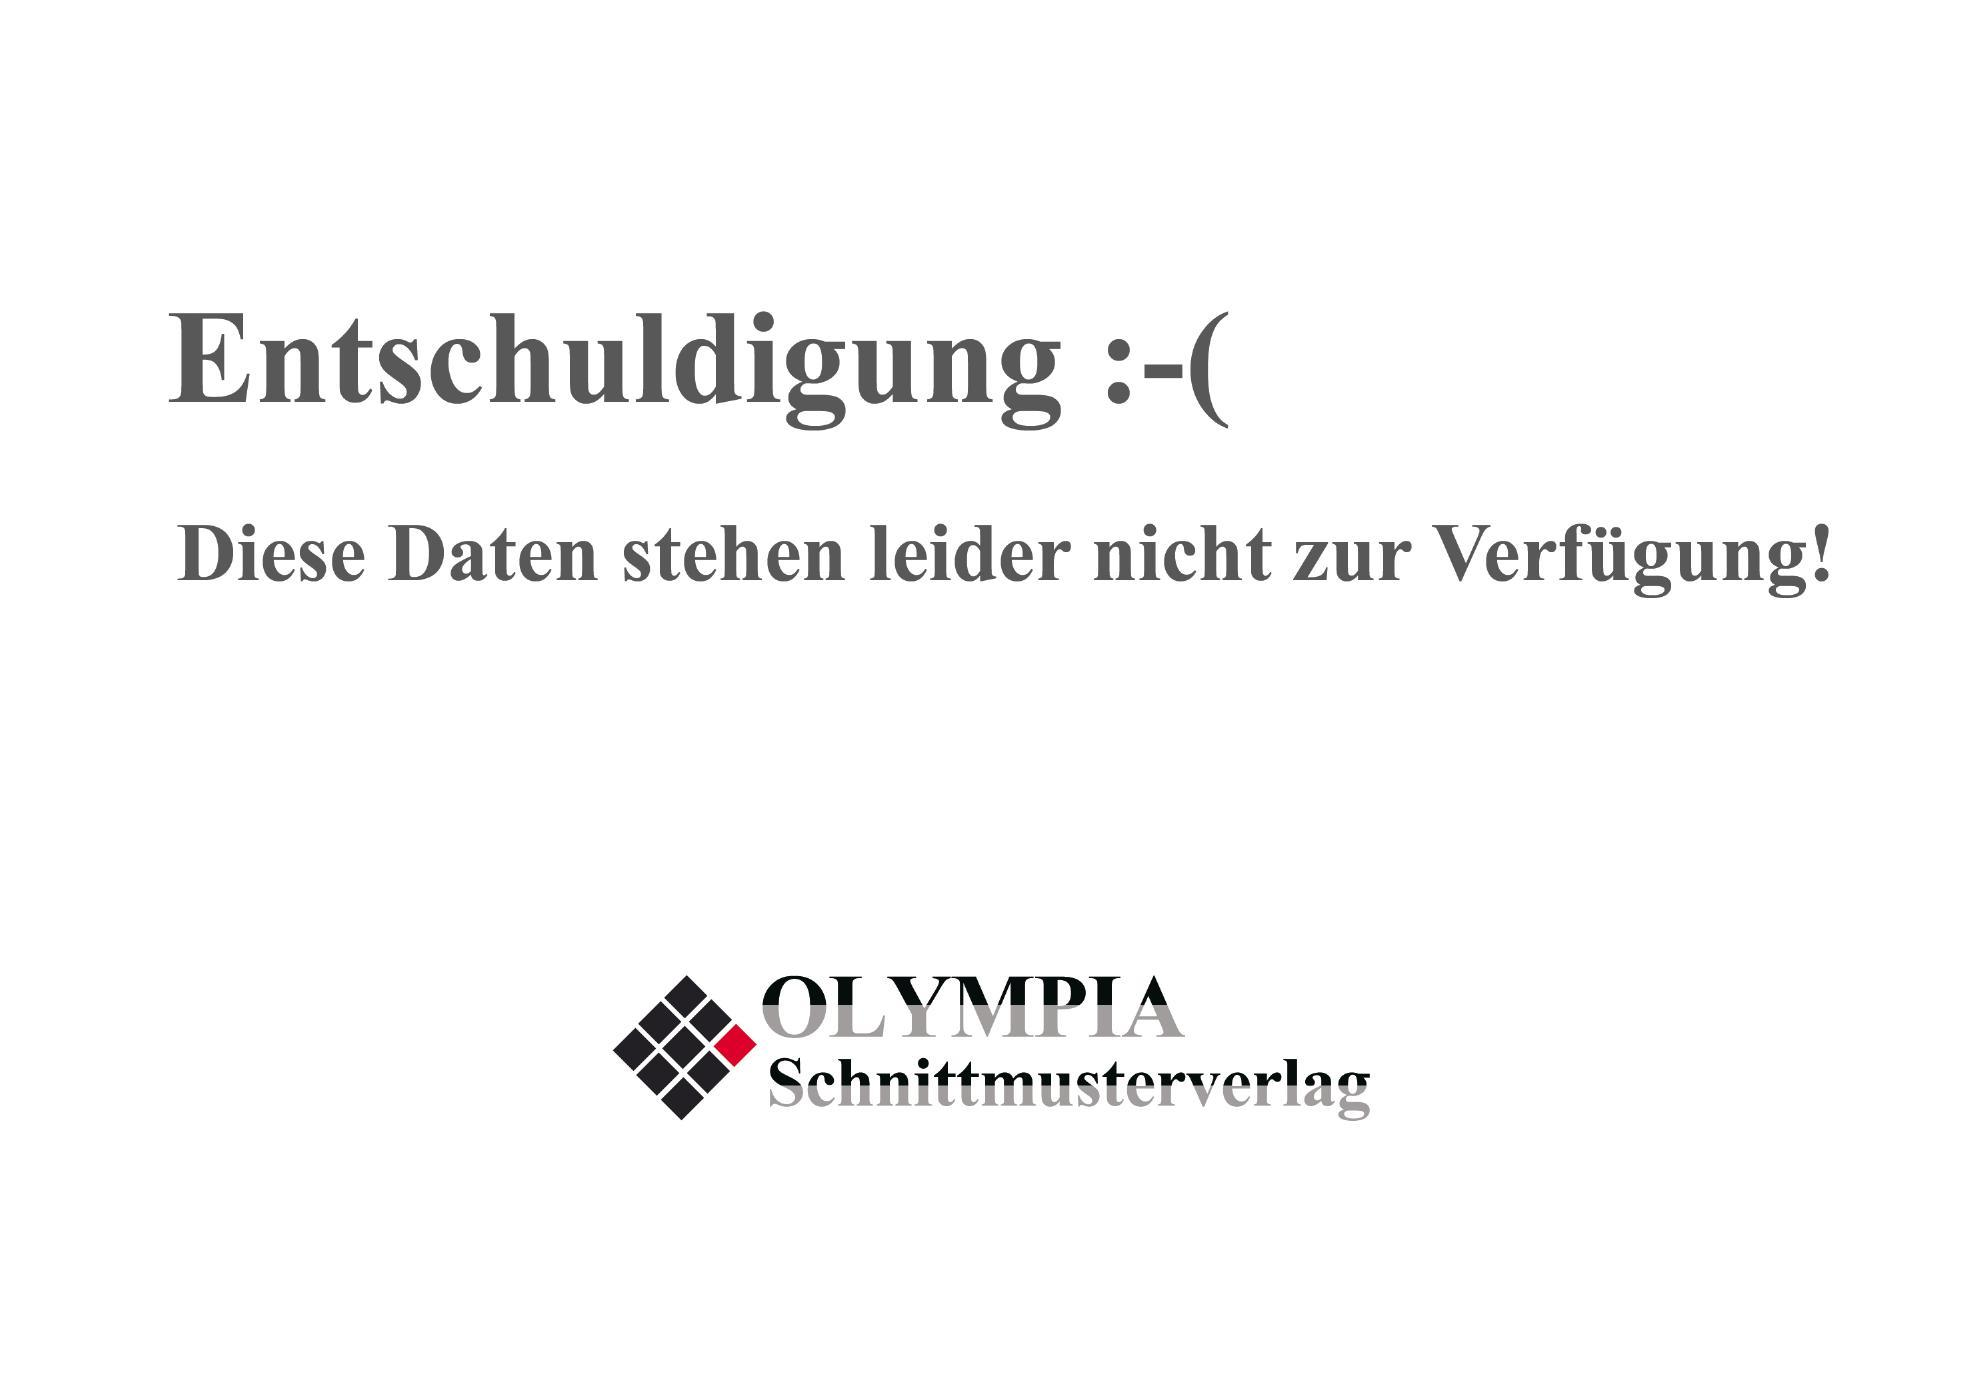

In [20]:
url = list(extraction.keys())[0]
print("url:", url)
print("\n")
print("EXTRACTION:")
res = extraction[url]["metadata"]
print(json.dumps(res, indent=4, ensure_ascii=False))
from IPython.display import Image

file_name = mappings_img[url]
file_path = os.path.join(IMAGE_PATH, file_name)
Image(filename=file_path)